In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.rcParams['font.size'] = 16

In [34]:
def dTdt(t, T, r, Tamb):
    return r * (Tamb - T)

In [ ]:
r = 0.05
Tamb = 25   # Temperatura ambiente
T0 = 90     # Temperatura inicial
t = (0, 200)
Dt = np.linspace(t[0], t[1], 100)

In [49]:
sol = solve_ivp(dTdt, t, [T0], args=(r, Tamb), t_eval=Dt, method='RK45')

T_analytical = Tamb + (T0 - Tamb) * np.exp(-r * Dt)

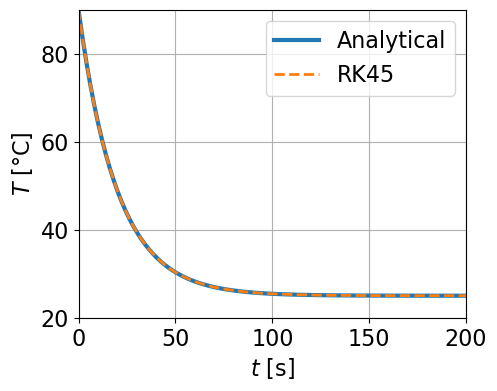

In [56]:
plt.figure(figsize=(5, 4))
plt.plot(Dt, T_analytical, label='Analytical', ls='-', lw=3)
plt.plot(Dt, sol.y[0], label='RK45', ls='--', lw=2)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$T$ [°C]")
plt.legend()
plt.xlim(t[0], t[1])
plt.ylim(20, T0)
plt.grid(True)
plt.show()